In [2]:
import numpy as np
import pandas as pd
import itertools

from scipy import stats
from statsmodels.stats.descriptivestats import sign_test
from statsmodels.stats.weightstats import zconfint
from statsmodels.stats.weightstats import *

In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Недвижимость в Сиэттле

In [4]:
seattle_data = pd.read_csv('data/seattle.txt', sep="\t", header=0)

In [5]:
seattle_data.shape

(100, 2)

In [6]:
seattle_data.head()

,Price,Year
0,142.0,2002
1,232.0,2002
2,132.5,2002
3,200.0,2002
4,362.0,2002


In [7]:
price2001 = seattle_data[seattle_data['Year'] == 2001].Price
price2002 = seattle_data[seattle_data['Year'] == 2002].Price

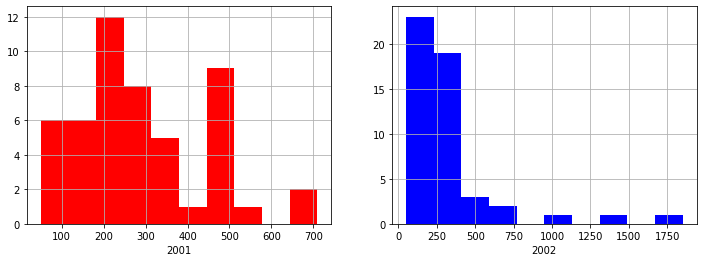

In [10]:
pylab.figure(figsize=(12, 4))

pylab.subplot(1, 2, 1)
pylab.grid()
pylab.hist(price2001, color='r')
pylab.xlabel('2001')

pylab.subplot(1, 2, 2)
pylab.grid()
pylab.hist(price2002, color='b')
pylab.xlabel('2002');

### Двухвыборочные критерии для независимых выборок

H0: Медианы стоимости совпадают  
H1: Не совпадают

In [11]:
zconfint(price2001)

(245.19358064978286, 332.65949935021723)

In [12]:
zconfint(price2002)

(241.4379457326015, 417.07633426739847)

#### Ранговый критерий Манна-Уитни

$H_0\colon F_{X_1}(x) = F_{X_2}(x)$

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

In [14]:
stats.mannwhitneyu(price2001, price2002)

MannwhitneyuResult(statistic=1295.5, pvalue=0.7563872675701748)

#### Перестановочный критерий

$H_0\colon F_{X_1}(x) = F_{X_2}(x)$

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

In [32]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

def get_random_combinations(n1, n2, max_combinations):
    index = list(range(n1 + n2))
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

def permutation_zero_dist_ind(sample1, sample2, max_combinations=None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) for index in itertools.combinations(range(n), n1)]
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() for i in indices]
    return distr

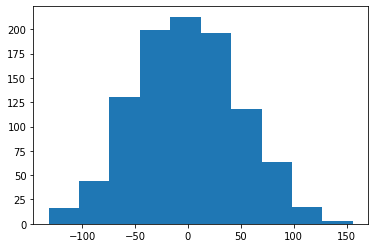

In [26]:
pylab.hist(permutation_zero_dist_ind(price2001, price2002, max_combinations=1000));

In [34]:
def permutation_test(sample, mean, max_permutation=None, alternative="two-sided"):
    if alternative not in ("two-sided", "less", "greater"):
        raise ValueError("alternative not recognized\nshould be 'two-sided', 'less' or 'greater'")
    t_stat = permutation_t_stat_ind(sample, mean)
    zero_distr = permutation_zero_dist_ind(sample, mean, max_permutation)
    if alternative == 'two-sided':
        return sum([1 if abs(x) >= abs(t_stat) else 0 for x in zero_distr]) / len(zero_distr)
    if alternative == 'less':
        return sum([1 if x <= t_stat else 0 for x in zero_distr]) / len(zero_distr)
    if alternative == 'greater':
        return sum([1 if x >= t_stat else 0 for x in zero_distr]) / len(zero_distr)

In [35]:
permutation_test(price2001, price2002, max_permutation=10000), permutation_test(price2001, price2002, max_permutation=50000)

(0.4395, 0.44622)